# 异常检测

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white", palette=sns.color_palette("RdBu"))

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats
from sklearn.model_selection import train_test_split

You want to divide data into 3 set.
> Training set  
> Cross Validation set  
> Test set  

You shouldn't be doing prediction using training data or Validation data as it does in the exercise

In [6]:
mat = sio.loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [7]:
X = mat.get('X')

divide original validation data into validation and test set

In [8]:
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'), mat.get('yval').ravel(), test_size=0.5)

# Visualize training data

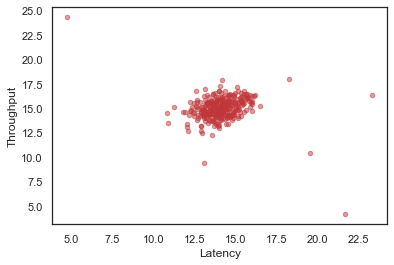

In [10]:
sns.regplot(x='Latency', y='Throughput', data=pd.DataFrame(X, columns=['Latency', 'Throughput']),
            fit_reg=False, scatter_kws={"s":20, "alpha":0.5})
plt.show()

# estimate multivatiate Gaussian parameters /u and /sigma^2

> according to data, X1, and X2 is not independent

In [11]:
mu = X.mean(axis=0)
print(mu, '\n')

cov = np.cov(X.T)
print(cov)

[14.11222578 14.99771051] 

[[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


In [13]:
# example of creating 2d grid to calculate probability density
np.dstack(np.mgrid[0:3, 0:3])

array([[[0, 0],
        [0, 1],
        [0, 2]],

       [[1, 0],
        [1, 1],
        [1, 2]],

       [[2, 0],
        [2, 1],
        [2, 2]]])

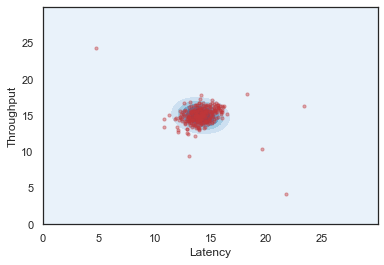

In [16]:
# create multi-var Gaussian model
multi_normal = stats.multivariate_normal(mu, cov)

#create a grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original data points
sns.regplot(x='Latency', y='Throughput', data=pd.DataFrame(X, columns=['Latency', 'Throughput']),
            fit_reg=False, scatter_kws={"s":10, "alpha":0.4})
plt.show()

select threshold /ouga
> use training set X to model the multivariate Gaussian  
> use cross validation set (Xval, yval) to find the best /ouga by finding the best F-score

In [22]:
def select_threshold(X, Xval, yval):
    # create multivariate model using training data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)
    
    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)
    
    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)
    
    # calculate f-socre
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))
        
    # find the best f-score
    argmax_fs = np.argmax(fs)
    
    return epsilon[argmax_fs], fs[argmax_fs]

In [18]:
from sklearn.metrics import f1_score, classification_report

In [24]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 2.7101600950148493e-05
Best F-score on validation data: 0.8571428571428571


# visualize prediction of `Xval` using learned $\epsilon$
1. use CV data to find the best $\epsilon$
2. use all data (training + validation) to create model
3. do the prediction on test data

In [25]:
def select_threshold(X, Xval, yval):
    """use CV data to find the best epsilon
    Returns:
        e: best epsilon with the highest f-score
        f-score: such best f-score
    """
    # create multivariate model using training data
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)

    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    # calculate f-score
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))

    # find the best f-score
    argmax_fs = np.argmax(fs)

    return epsilon[argmax_fs], fs[argmax_fs]


def predict(X, Xval, e, Xtest, ytest):
    """with optimal epsilon, combine X, Xval and predict Xtest
    Returns:
        multi_normal: multivariate normal model
        y_pred: prediction of test data
    """
    Xdata = np.concatenate((X, Xval), axis=0)

    mu = Xdata.mean(axis=0)
    cov = np.cov(Xdata.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    # calculate probability of test data
    pval = multi_normal.pdf(Xtest)
    y_pred = (pval <= e).astype('int')

    print(classification_report(ytest, y_pred))

    return multi_normal, y_pred

In [26]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       149
           1       1.00      0.60      0.75         5

    accuracy                           0.99       154
   macro avg       0.99      0.80      0.87       154
weighted avg       0.99      0.99      0.99       154



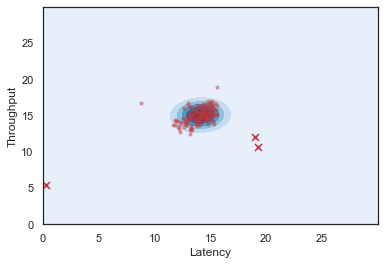

In [28]:
# construct test DataFrame
data = pd.DataFrame(Xtest, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

# create a grid for graphing
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original Xval points
sns.regplot(x='Latency', y='Throughput',
            data=data,
            fit_reg=False,
            ax=ax,
            scatter_kws={"s":10,
                         "alpha":0.4})

# mark the predicted anamoly of CV data. We should have a test set for this...
anamoly_data = data[data['y_pred']==1]
ax.scatter(anamoly_data['Latency'], anamoly_data['Throughput'], marker='x', s=50)
plt.show()

# high dimension data

In [29]:
mat = sio.loadmat('./data/ex8data2.mat')

In [30]:
X = mat.get('X')
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'),
                                            mat.get('yval').ravel(),
                                            test_size=0.5)

In [31]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 2.0400009791024007e-19
Best F-score on validation data: 0.8333333333333333


In [32]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        47
           1       0.50      0.67      0.57         3

    accuracy                           0.94        50
   macro avg       0.74      0.81      0.77        50
weighted avg       0.95      0.94      0.94        50



In [33]:
print('find {} anamolies'.format(y_pred.sum()))

find 4 anamolies


The huge difference between my result, and the official `117` anamolies in the ex8 is due to:
1. my use of **multivariate Gaussian**
2. I split data very differently